<a href="https://colab.research.google.com/github/CaQtiml/DeepLearning_Practice/blob/main/TransferLearning_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile
import os
import datetime
import random


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Jul 17 12:29:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating Helper Function

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-17 12:29:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-17 12:29:18 (109 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data.

In [ ]:
# Get 10% of the data of the 10 classes
if os.path.isdir('./10_food_classes_10_percent')==False:
  !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 
  unzip_data("10_food_classes_10_percent.zip")

--2021-07-17 12:29:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  53.4MB/s    in 3.0s    

2021-07-17 12:29:22 (53.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

## Import data with the different way from the lastest notebook.

In [ ]:
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [ ]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# Or if we wanted to see an example batch of data, we could use the take() method.
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

## Building a transfer learning model using the Keras Functional API (NOT USING SEQUENTIAL)

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

In [ ]:
base_model.trainable = False

In [ ]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

In [ ]:
# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

In [ ]:
x= base_model(inputs)
print(x.shape)

(None, 7, 7, 1280)


In [ ]:
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

After GlobalAveragePooling2D(): (None, 1280)


In [ ]:
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

In [ ]:
model_0 = tf.keras.Model(inputs, outputs)

In [ ]:
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20210717-035857
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 11s 261ms/step - loss: 1.9183 - accuracy: 0.4040 - val_loss: 1.3736 - val_accuracy: 0.6974
Epoch 2/5
24/24 [==============================] - 5s 189ms/step - loss: 1.1567 - accuracy: 0.7413 - val_loss: 0.9328 - val_accuracy: 0.7993
Epoch 3/5
24/24 [==============================] - 5s 188ms/step - loss: 0.8347 - accuracy: 0.8213 - val_loss: 0.7661 - val_accuracy: 0.8158
Epoch 4/5
24/24 [==============================] - 4s 165ms/step - loss: 0.7015 - accuracy: 0.8280 - val_loss: 0.6726 - val_accuracy: 0.8438
Epoch 5/5
24/24 [==============================] - 4s 160ms/step - loss: 0.5950 - accuracy: 0.8533 - val_loss: 0.5957 - val_accuracy: 0.8569


In [ ]:
model_0.layers

In [ ]:
for layer in model_0.layers:
  print(layer.trainable)

True
False
True
True


In [ ]:
base_model.summary()

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


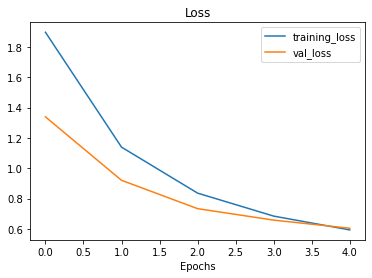

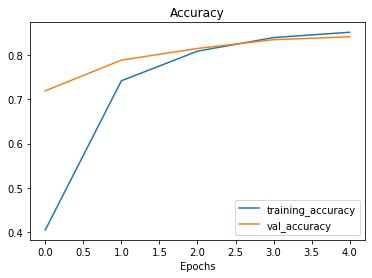

In [ ]:
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model (GlobalAveragePooling2D Explained)

🤔 Question: What happens with the `tf.keras.layers.GlobalAveragePooling2D()` layer? I haven't seen it before.

The `tf.keras.layers.GlobalAveragePooling2D()` layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

In [ ]:
# Define input tensor shape (same number of dimensions as the output of efficientnetb0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor[0]}\n")
print(f"Random input tensor:\n {input_tensor[0,0,:,:]}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[ 0.3274685  -0.8426258   0.3194337 ]
  [-1.4075519  -2.3880599  -1.0392479 ]
  [-0.5573232   0.539707    1.6994323 ]
  [ 0.28893656 -1.5066116  -0.2645474 ]]

 [[-0.59722406 -1.9171132  -0.62044144]
  [ 0.8504023  -0.40604794 -3.0258412 ]
  [ 0.9058464   0.29855987 -0.22561555]
  [-0.7616443  -1.8917141  -0.93847126]]

 [[ 0.77852213 -0.47338897  0.97772694]
  [ 0.24694404  0.20573747 -0.5256233 ]
  [ 0.32410017  0.02545409 -0.10638497]
  [-0.6369475   1.1603122   0.2507359 ]]

 [[-0.41728503  0.4012578  -1.4145443 ]
  [-0.5931857  -1.6617213   0.33567193]
  [ 0.10815629  0.23479682 -0.56668764]
  [-0.35819843  0.88698614  0.52744764]]]

Random input tensor:
 [[ 0.3274685  -0.8426258   0.3194337 ]
 [-1.4075519  -2.3880599  -1.0392479 ]
 [-0.5573232   0.539707    1.6994323 ]
 [ 0.28893656 -1.5066116  -0.2645474 ]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged poo

You can see the `tf.keras.layers.GlobalAveragePooling2D()` layer condensed the input tensor from shape (1, 4, 4, 3) to (1, 3). It did so by averaging the input_tensor across the middle two axes.

We can replicate this operation using the `tf.reduce_mean()` operation and specifying the appropriate axes.

In [ ]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1,2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

# Running a series of transfer learning experiments

1. model_1 - use feature extraction transfer learning with 1% of the training data with data augmentation
2. model_2 - use feature extraction transfer learning with 10% of the training with data augmentaton
3. model_3 - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. model_4 - use fine-tuning transfer learning on 100% of the training data with data augmentation

In [ ]:
if os.path.isdir('./10_food_classes_1_percent')==False:
  !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip 
  unzip_data("10_food_classes_1_percent.zip")

In [ ]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

IMG_SIZE = (224, 224)

In [ ]:
# How many images are we working with?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'

🔑 Note: As with the 10% of data subset, the 1% of images were chosen at random from the original full training dataset. The test images are the same as the ones which have previously been used. If you want to see how this data was preprocessed, check out the [Food Vision Image Preprocessing notebook.](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb)

In [ ]:
# Setup data loaders 
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE) # default = 32

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model (Without ImageDataGenerator Class)

Reminder : Add data augmentation only in ***TRAINING SET***

In [ ]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

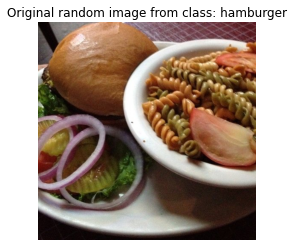

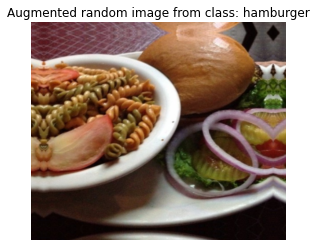

In [ ]:
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/"+ target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

augmented_img = data_augmentation(tf.expand_dims(img,axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
INPUT_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=INPUT_SHAPE,
                      name="input_layer")

x = data_augmentation(inputs)

# x = base_model(x)
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210717-041854
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 10s 2s/step - loss: 2.4331 - accuracy: 0.0571 - val_loss: 2.3249 - val_accuracy: 0.1201
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1878 - accuracy: 0.2143 - val_loss: 2.1965 - val_accuracy: 0.1924
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 2.0278 - accuracy: 0.3286 - val_loss: 2.0867 - val_accuracy: 0.2632
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7958 - accuracy: 0.5286 - val_loss: 1.9872 - val_accuracy: 0.3454
Epoch 5/5
3/3 [==============================] - 2s 1s/step - loss: 1.6405 - accuracy: 0.6714 - val_loss: 1.8993 - val_accuracy: 0.4079


In [ ]:
model_1.layers

In [ ]:
for layer in model_1.layers:
  print(layer.trainable)

True
True
False
True
True


In [ ]:
# Check out model summary
model_1.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 7s 86ms/step - loss: 1.8794 - accuracy: 0.4356


[1.8793554306030273, 0.43560001254081726]

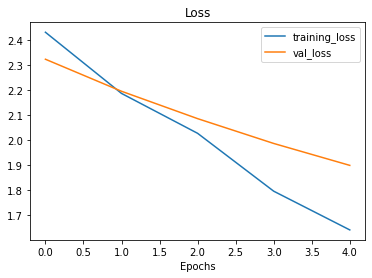

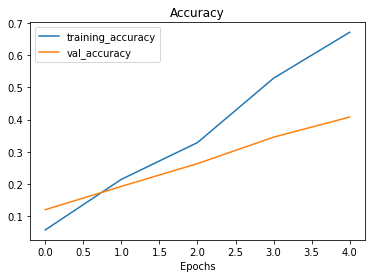

In [ ]:
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning with 10% of data and data augmentation

In [ ]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
train_data_10_percent = image_dataset_from_directory(train_dir_10_percent,
                                                     label_mode="categorical",
                                                     image_size=IMG_SIZE)
test_data = image_dataset_from_directory(test_dir,
                                         label_mode="categorical",
                                         image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
],name="data_augmentation")

In [ ]:
INPUT_SHAPE = IMG_SIZE+(3,)

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = layers.Input(shape=INPUT_SHAPE,name="input_layer")
x = data_augmentation(inputs)
x = base_model(x,training=False)
x = layers.GlobalAveragePooling2D(name="GlobalPooling2D")(x)
outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)
model_2 = tf.keras.Model(inputs,outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

16711680/16705208 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Creating a ModelCheckpoint callback

In [ ]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210717-122959
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 28s 379ms/step - loss: 1.9185 - accuracy: 0.3893 - val_loss: 1.4180 - val_accuracy: 0.6875

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 6s 257ms/step - loss: 1.3308 - accuracy: 0.6707 - val_loss: 1.0221 - val_accuracy: 0.7763

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 6s 255ms/step - loss: 1.0563 - accuracy: 0.7387 - val_loss: 0.8372 - val_accuracy: 0.8043

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 6s 250ms/step - loss: 0.8881 - accuracy: 0.7693 - val_loss: 0.7506 - val_accuracy: 0.8174

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 6s 243ms/step - loss: 0.7949 - accuracy: 0.7827 - val_loss

In [ ]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 7s 88ms/step - loss: 0.6903 - accuracy: 0.8132


[0.6902880072593689, 0.8131999969482422]

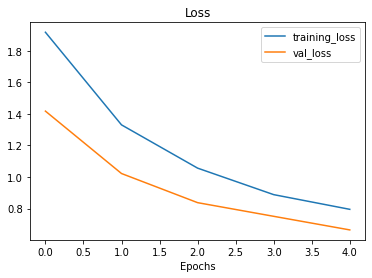

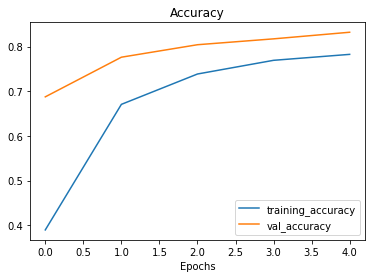

In [ ]:
plot_loss_curves(history_10_percent_data_aug)

### Save the model weight

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 88ms/step - loss: 0.6903 - accuracy: 0.8132


In [ ]:
print(loaded_weights_model_results[1],results_10_percent_data_aug[1]) # nearly exactly same

0.8131999969482422 0.8131999969482422


## Model 3: Fine-tuning an existing model on 10% of the data

### Model_2 layers detail

In [ ]:
model_2.layers

In [ ]:
for layer in model_2.layers:
  print(layer.trainable)

True
True
False
True
True


In [ ]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

In [ ]:
model_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
GlobalPooling2D (GlobalAvera (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
# How many layers are trainable in our base model?
print(len(model_2.trainable_variables))
# for i in range(5):
#   print(len(model_2.layers[i].trainable_variables))
# print(model_2.layers[4].trainable_variables) # 2 trainable_params: weight and bias
# print(model_2.layers[4].trainable_variables[1])
print(len(model_2.layers[2].trainable_variables)) # layer at index 2 is the EfficientNetB0 layer (the base model)
# This is the same as our base model.
print(len(base_model.trainable_variables))

2
0
0


In [ ]:
# We can even check layer by layer to see if the they're trainable.
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
X = np.arange(0,10)
print(X[:-1])

[0 1 2 3 4 5 6 7 8]


### Model 3

In [ ]:
#***********************IMPORTANT PART*****************************

# Unfreeze the last 10 layers
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

#*******************************************************************

# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

# The change at base_model will automatically apply at model_2

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
# The change at base_model will automatically apply at model_2
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
print(len(model_2.trainable_variables))

12


In [ ]:
model_2.layers

In [ ]:
for layer in model_2.layers:
  print(layer.trainable)

True
True
True
True
True


In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25 * len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                      experiment_name="10_percent_fine_tune_last_10")])
# ***THE CHECKPOINT ISN'T CREATED HERE!!!***
# because we will learn how to revert the model using checkpoint at the model_4

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210717-123823
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 14s 335ms/step - loss: 0.6871 - accuracy: 0.8093 - val_loss: 0.5764 - val_accuracy: 0.8289
Epoch 6/10
24/24 [==============================] - 6s 228ms/step - loss: 0.5509 - accuracy: 0.8253 - val_loss: 0.5148 - val_accuracy: 0.8388
Epoch 7/10
24/24 [==============================] - 6s 220ms/step - loss: 0.5133 - accuracy: 0.8400 - val_loss: 0.5128 - val_accuracy: 0.8322
Epoch 8/10
24/24 [==============================] - 6s 239ms/step - loss: 0.4683 - accuracy: 0.8453 - val_loss: 0.5208 - val_accuracy: 0.8339
Epoch 9/10
24/24 [==============================] - 6s 219ms/step - loss: 0.4167 - accuracy: 0.8587 - val_loss: 0.4609 - val_accuracy: 0.8536
Epoch 10/10
24/24 [==============================] - 5s 203ms/step - loss: 0.3819 - accuracy: 0.8720 - val_loss: 0.4766 - val_accuracy: 0.8470


In [ ]:
# Evaluate the fine-tuned model (model_3 which is actualy model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 87ms/step - loss: 0.5047 - accuracy: 0.8332


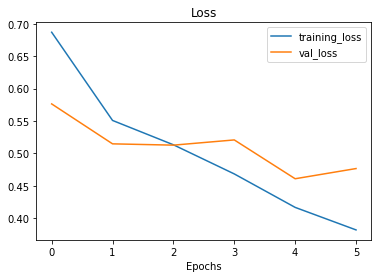

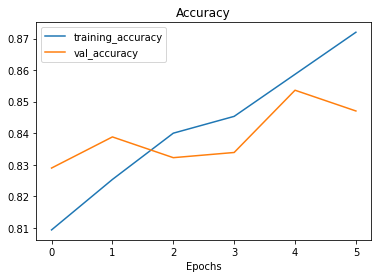

In [ ]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

In [ ]:
# history_10_percent_data_aug
# history_fine_10_percent_data_aug

In [ ]:
def compare_histories(original,new,initial_epochs=5):
  acc = original.history["accuracy"] + new.history["accuracy"]
  loss = original.history["loss"] + new.history["loss"]
  val_acc = original.history["val_accuracy"] + new.history["val_accuracy"]
  val_loss = original.history["val_loss"] + new.history["val_loss"]

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc,label="Training Accuracy")
  plt.plot(val_acc,label="Val Accuracy")
  plt.axvline(x=5)

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(loss,label="Training Loss")
  plt.plot(val_loss,label="Val Loss")
  plt.axvline(x=5)

  

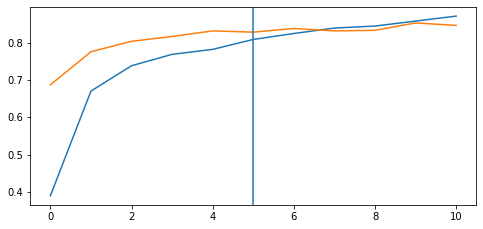

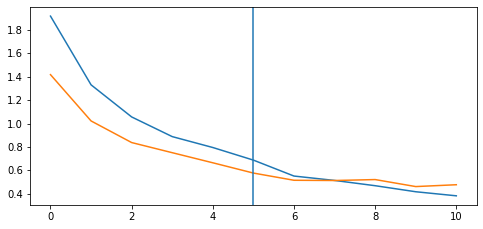

In [ ]:
compare_histories(history_10_percent_data_aug,history_fine_10_percent_data_aug)

Alright, alright, seems like the curves are heading in the right direction after fine-tuning. But remember, it should be noted that <font color="seablue">fine-tuning usually works best with larger amounts of data.</font>

## Model 4: Fine-tuning an existing model all of the data

In [ ]:
if os.path.isdir('./10_food_classes_all_data')==False:
  !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
  unzip_data("10_food_classes_all_data.zip")

--2021-07-17 13:00:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  96.6MB/s    in 5.3s    

2021-07-17 13:00:40 (93.9 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"
IMG_SIZE = (224, 224)

train_data_10_classes_full = image_dataset_from_directory(train_dir,
                                                          label_mode="categorical",
                                                          image_size=IMG_SIZE)
test_data_10_classes_full = image_dataset_from_directory(test_dir,
                                                         label_mode="categorical",
                                                         image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


As it is now, our model_2 has been fine-tuned on 10 percent of the data, so to begin fine-tuning on all of the data and keep our experiments consistent, we need to revert it back to the weights we checkpointed after 5 epochs of feature-extraction

In [ ]:
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"
model_2.load_weights(checkpoint_path) # revert model back to saved weights

In [ ]:
model_2.evaluate(test_data)
print(results_10_percent_data_aug) ## from model_2

## Both accuracy and loss are same. => revert complete

79/79 [==============================] - 7s 87ms/step - loss: 0.6903 - accuracy: 0.8132
[0.6902880072593689, 0.8131999969482422]


Things we have done.

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using ModelCheckpoint.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.
3. Saved the results and training logs each time.

Things we will do.

1. Reloaded the model from 1 to do the same steps as 2 but with all of the data.

In [ ]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 GlobalPooling2D True
4 output_layer True


The last 10 layers of model_2 is already still unfreezed .
We load only the weight, but unfreezed layers still unchanged.

In [ ]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

In [ ]:
## Don't forget to recompile the model_2
model_2.compile(loss="categorical_crossentropy",
                optimizer=Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
            epochs=fine_tune_epochs,
            initial_epoch=history_10_percent_data_aug.epoch[-1],
            validation_data=test_data_10_classes_full,
            validation_steps=len(test_data_10_classes_full),
            callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20210717-134512
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 34s 144ms/step - loss: 0.3938 - accuracy: 0.8708 - val_loss: 0.3160 - val_accuracy: 0.8976
Epoch 6/10
235/235 [==============================] - 33s 140ms/step - loss: 0.3738 - accuracy: 0.8809 - val_loss: 0.3319 - val_accuracy: 0.8932
Epoch 7/10
235/235 [==============================] - 33s 137ms/step - loss: 0.3519 - accuracy: 0.8865 - val_loss: 0.3046 - val_accuracy: 0.9008
Epoch 8/10
235/235 [==============================] - 33s 138ms/step - loss: 0.3438 - accuracy: 0.8881 - val_loss: 0.3164 - val_accuracy: 0.8988
Epoch 9/10
235/235 [==============================] - 32s 133ms/step - loss: 0.3144 - accuracy: 0.8972 - val_loss: 0.3234 - val_accuracy: 0.8932
Epoch 10/10
235/235 [==============================] - 33s 138ms/step - loss: 0.2906 - accuracy: 0.9055 - val_loss: 0.3062 - val_accuracy: 0.9008


In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 7s 85ms/step - loss: 0.3062 - accuracy: 0.9008


[0.3061628043651581, 0.9007999897003174]

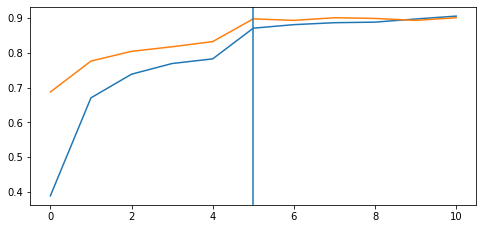

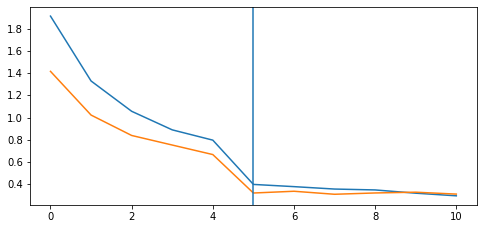

In [ ]:
compare_histories(history_10_percent_data_aug,history_fine_10_classes_full)